# Autoencoder

In [120]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from scipy.misc import imresize, imsave
import json
from copy import deepcopy
from sklearn.model_selection import train_test_split
from time import time #importamos la función time para capturar tiempos

print(os.path.abspath('.'))
from matplotlib import pyplot

import keras
from keras.datasets import mnist
from keras.models import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

C:\Users\thoma\Documents\GitHub\Proyecto-EL4106-


In [121]:
#Se cargan los datos de entrenamiento
imags_super = np.load("super_orig.pickle")
mapas_super = np.load("super_oclu.pickle")

imags_no = np.load("no_orig.pickle")
mapas_no = np.load("no_oclu.pickle")

In [122]:
mapas_super[1].shape

(21, 21)

In [139]:
x=[]
input_img = Input(shape=(25, 25, 4))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (4, 4), input_shape = (25, 25, 4), padding="same",strides=(1, 1), activation = 'relu')(input_img)
x = Conv2D(32, (3, 3), padding="same", activation = 'relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3),padding="same", activation = 'relu')(x)
x = Conv2D(64, (3, 3),padding="same", activation = 'relu')(x)
x = Conv2D(64, (3, 3),padding="same", activation = 'relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(64, (3, 3),padding="same", activation = 'relu')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3),padding="same", activation = 'relu')(x)
x = Conv2D(64, (3, 3),padding="valid", activation = 'relu')(x)
x =Conv2D(32, (3, 3), padding="same", activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)
x =Conv2D(32, (4, 4), input_shape = (25, 25, 4), padding="valid",strides=(1, 1), activation = 'relu')(x)
decoded = Conv2D(1, (2, 2), activation='relu',padding='same')(x)
#decoded = decoded[:,:21,:21,:]

autoencoder = Model(input_img, decoded)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

autoencoder.compile(optimizer='adam', loss='mse')

In [124]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 25, 25, 32)        2080      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 13, 13, 64)        36928     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 13, 13, 64)        36928     
__________

In [125]:
def reformat_imgs(input):

    x = np.zeros((len(input), 25, 25, 4))#nuevo arreglo
    for i in range(len(input)):
        x[i, :,:,0] = input[i][:,:,0]
        x[i, :,:,1] = input[i][:,:,1]
        x[i, :,:,2] = input[i][:,:,2]
        x[i, :,:,3] = input[i][:,:,3]

    return x


def reformat_mapas(input):
    x = np.zeros((len(input), 21, 21, 1))#nuevo arreglo
    for i in range(len(input)):
        x[i, :,:,0] = input[i][:,:]
    return x


In [126]:
from keras.datasets import mnist
import numpy as np

imags=np.concatenate((imags_super, imags_no))
mapas=np.concatenate((mapas_super, mapas_no))

x_train, x_test, y_train, y_test = train_test_split(imags, mapas, test_size=0.2)

x_train=reformat_imgs(x_train)
x_test=reformat_imgs(x_test)
y_train=reformat_mapas(y_train)
y_test=reformat_mapas(y_test)

In [127]:
y_test.shape


(5543, 21, 21, 1)

In [140]:
class_log = autoencoder.fit(x_train, y_train,
                epochs=15,
                batch_size=64,
                validation_data=(x_test, y_test),callbacks=[es])

Train on 22171 samples, validate on 5543 samples
Epoch 1/15
22171/22171 [==============================] - 101s 5ms/step - loss: 6.3816 - val_loss: 2.1611
Epoch 2/15
22171/22171 [==============================] - 102s 5ms/step - loss: 1.7255 - val_loss: 1.2119
Epoch 3/15
22171/22171 [==============================] - 102s 5ms/step - loss: 1.2547 - val_loss: 1.1534
Epoch 4/15
22171/22171 [==============================] - 100s 4ms/step - loss: 0.8794 - val_loss: 0.9080
Epoch 5/15
22171/22171 [==============================] - 101s 5ms/step - loss: 0.8013 - val_loss: 0.8918
Epoch 6/15
22171/22171 [==============================] - 98s 4ms/step - loss: 0.7253 - val_loss: 0.6177
Epoch 7/15
22171/22171 [==============================] - 99s 4ms/step - loss: 0.7455 - val_loss: 0.5443
Epoch 8/15
22171/22171 [==============================] - 98s 4ms/step - loss: 0.5752 - val_loss: 0.6015
Epoch 9/15
22171/22171 [==============================] - 98s 4ms/step - loss: 0.5472 - val_loss: 0.6781
E

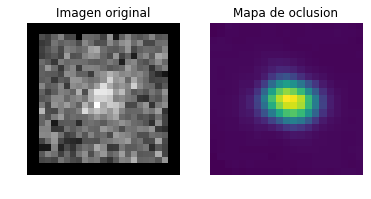

In [150]:

%matplotlib inline
nume=5
img = x_test[nume]
target=autoencoder.predict(x_test[nume:nume+1])[0,:,:,0]
plt.subplot(121)
plt.imshow(img[:,:,1],cmap="gray"); plt.axis("off")
plt.title("Imagen original")
plt.subplot(122)
plt.imshow(target); plt.axis("off")
plt.title('Mapa de oclusion')
plt.show()


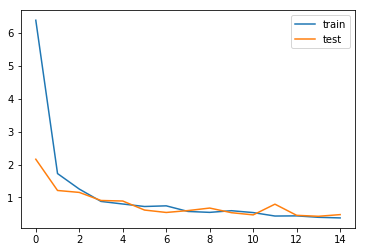

In [142]:
#_, train_acc = autoencoder.evaluate(x_train, y_train, verbose=1)
#_, test_acc = autoencoder.evaluate(x_test, y_test, verbose=1)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(class_log.history['loss'], label='train')
pyplot.plot(class_log.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [143]:
#######  AUTOENCODER CON LOS PESOS DEL CLASIFICADOR  ########
#Se cargan los pesos sacados del clasificador

pesos1=np.load("pesos1.npy")
pesos2=np.load("pesos2.npy")
pesos3=np.load("pesos3.npy")
pesos4=np.load("pesos4.npy")
pesos5=np.load("pesos5.npy")

In [144]:
#Montaje del autoencoder
x1=[]
input_img1 = Input(shape=(25, 25, 4))  # adapt this if using `channels_first` image data format

x1 = Conv2D(32, (4, 4), input_shape = (25, 25, 4), padding="same",strides=(1, 1), activation = 'relu',trainable=False)(input_img1)
x1 = Conv2D(32, (3, 3), padding="same", activation = 'relu',trainable=False)(x1)
x1 = MaxPooling2D((2, 2), padding='same')(x1)
x1 = Conv2D(64, (3, 3),padding="same", activation = 'relu',trainable=False)(x1)
x1 = Conv2D(64, (3, 3),padding="same", activation = 'relu',trainable=False)(x1)
x1 = Conv2D(64, (3, 3),padding="same", activation = 'relu',trainable=False)(x1)
encoded1 = MaxPooling2D((2, 2), padding='same')(x1)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x1 = Conv2D(64, (3, 3),padding="same", activation = 'relu')(encoded1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(64, (3, 3),padding="same", activation = 'relu')(x1)
x1 = Conv2D(64, (3, 3),padding="valid", activation = 'relu')(x1)
x1 =Conv2D(32, (3, 3), padding="same", activation = 'relu')(x1)
x1 = UpSampling2D((2, 2))(x1)
x1 =Conv2D(32, (4, 4), input_shape = (25, 25, 4), padding="valid",strides=(1, 1), activation = 'relu')(x1)
decoded1 = Conv2D(1, (2, 2), activation='relu',padding='same')(x1)
#decoded = decoded[:,:21,:21,:]

autoencoder1 = Model(input_img1, decoded1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

autoencoder1.compile(optimizer='adam', loss='mse')

In [145]:
print(autoencoder1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 25, 25, 32)        2080      
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 13, 13, 64)        36928     
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 13, 13, 64)        36928     
__________

In [146]:
#Acá se le dan nombres a las capas de interés para cargarle los pesos
capa1=autoencoder1.layers[1]
capa1.set_weights(pesos1)

capa2=autoencoder1.layers[2]
capa2.set_weights(pesos2)

capa3=autoencoder1.layers[4]
capa3.set_weights(pesos3)

capa4=autoencoder1.layers[5]
capa4.set_weights(pesos4)

capa5=autoencoder1.layers[6]
capa5.set_weights(pesos5)


In [147]:
capa5

In [148]:
class_log1 = autoencoder1.fit(x_train, y_train,
                epochs=15,
                batch_size=64,
                validation_data=(x_test, y_test),callbacks=[es])

Train on 22171 samples, validate on 5543 samples
Epoch 1/15
22171/22171 [==============================] - 76s 3ms/step - loss: 2.4966 - val_loss: 0.6914
Epoch 2/15
22171/22171 [==============================] - 72s 3ms/step - loss: 0.5719 - val_loss: 0.6433
Epoch 3/15
22171/22171 [==============================] - 115s 5ms/step - loss: 0.4568 - val_loss: 0.6936
Epoch 4/15
22171/22171 [==============================] - 190s 9ms/step - loss: 0.3784 - val_loss: 0.4211
Epoch 5/15
22171/22171 [==============================] - 190s 9ms/step - loss: 0.3170 - val_loss: 0.3338
Epoch 6/15
22171/22171 [==============================] - 192s 9ms/step - loss: 0.2873 - val_loss: 0.3979
Epoch 7/15
22171/22171 [==============================] - 152s 7ms/step - loss: 0.2678 - val_loss: 0.4433
Epoch 8/15
22171/22171 [==============================] - 16414s 740ms/step - loss: 0.2590 - val_loss: 0.3137
Epoch 9/15
22171/22171 [==============================] - 72s 3ms/step - loss: 0.2421 - val_loss: 0.3

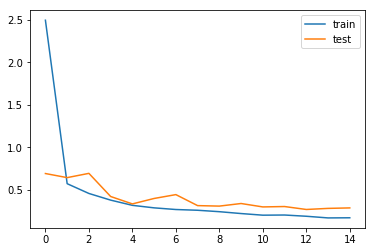

In [149]:
#_, train_acc = autoencoder.evaluate(x_train, y_train, verbose=1)
#_, test_acc = autoencoder.evaluate(x_test, y_test, verbose=1)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
pyplot.plot(class_log1.history['loss'], label='train')
pyplot.plot(class_log1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

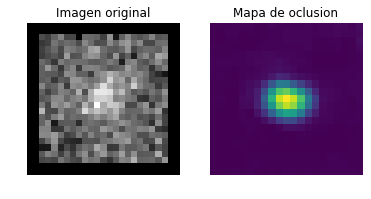

In [151]:
%matplotlib inline
nume=5
img = x_test[nume]
target=autoencoder1.predict(x_test[nume:nume+1])[0,:,:,0]
plt.subplot(121)
plt.imshow(img[:,:,1],cmap="gray"); plt.axis("off")
plt.title("Imagen original")
plt.subplot(122)
plt.imshow(target); plt.axis("off")
plt.title('Mapa de oclusion')
plt.show()
